We are testing the performance of different attack parameters below, using the actions and clean observations from the optimal BB attack. Because the ASR was 1 we effectively have a sample and label for every timestep, where the previous action lead to the next clean observation. We can treat this as a supervised learning problem since we effectively have a label for each observation/sample. Unlike the untargeted attack, the actions are not chsen randomly. Given that CityLearn is deterministic we expect that the optinal adversarial trace is also deterministic (confirm with multiple runs) in terms of the action associated with each observation. 

From below: 
- Does the vecorized search work for more than one sample input at the same time (that's how their input for rl, here it gets thousands at a time)
- Increasing the batchsize has a significant effect on speed
- we don't have an init for action 18, does that correspond to the incorrect preds?

This copy used ramdomstate.uniform in mybb

In [1]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500.zip'
ATTACK = 'myBB'


In [15]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from KBMproject.mybb import BrendelBethgeAttack as BBA

from art.utils import to_categorical

import pandas as pd
import numpy as np
import os

import KBMproject.utilities as utils

from joblib import Parallel, delayed

%matplotlib inline

Define RL agent

In [3]:
agent = PPO.load(path=f"{AGENT_NAME}")
print('Model loaded from storage')

Model loaded from storage


In [4]:
from art.estimators.classification import PyTorchClassifier as classifier
from torch.nn import CrossEntropyLoss
victim_policy = classifier(
    model=utils.extract_actor(agent),
    loss=CrossEntropyLoss(), 
    nb_classes=agent.action_space[0].n,
    input_shape=agent.observation_space.shape,
    device_type='gpu',
    clip_values = (agent.observation_space.low.min(),agent.observation_space.high.max()) #min and max values of each feature, brendle bethge attack only supports floats values and not array
    )

In [5]:
mask_time = np.ones(agent.observation_space.shape)
mask_time[:6] = 0

In [6]:
df_baseline = pd.concat([pd.read_csv('baseline_obs.csv', index_col=0,dtype='float32'),
                        pd.read_csv('baseline_obs_a_confidence.csv', index_col=0)], axis='columns')

Below, for each action we select the sample with the highest logit softmax/confidence

In [7]:
df_max_confidence_samples = df_baseline.loc[df_baseline.groupby('action')['confidence'].idxmax()]
df_max_confidence_samples = df_max_confidence_samples.drop(columns='confidence')
df_max_confidence_samples = df_max_confidence_samples.set_index('action')

In [8]:
dict_samples = df_max_confidence_samples.T.to_dict()

In [9]:
samples = pd.read_csv('bb results/optimal myBB observations.csv', index_col=0,dtype='float32')

In [10]:
inputs = samples.to_numpy()[:-1]

In [13]:
targets = np.argmax(victim_policy.predict(pd.read_csv('bb results/optimal myBB adversarial observations.csv',
                                            index_col=0,
                                            dtype='float32')
                                            ), axis=1)

In [17]:
categorical_targets = to_categorical(targets, nb_classes=agent.action_space[0].n)

In [97]:
np.unique(targets, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int64),
 array([1987, 2078,   25,    7,    2,    2,   45,   76,  185,  122,   56,
          31,   66,   43,   13,  118,   24,   22,  396, 3461], dtype=int64))

In [98]:
396/8759

0.04521064048407353

In [11]:
starts = np.array([np.array(list(
    dict_samples[a].values())).astype('float32') if a in dict_samples else np.zeros(agent.observation_space.shape, 'float32') for a in targets]) #there is no example for action 18

In [12]:
kwargs = dict(norm=2,
        targeted=True, #default false
        overshoot=1.1, #1.1,
        steps=1000,
        lr=1e-3,
        lr_decay=0.5,
        lr_num_decay=20,
        momentum=0.8,
        binary_search_steps=10,
        init_size=1_000_000, #default 100, finds sample matching the target class through iterative random search
        #batch_size=1, this makes it soooooo much worse, increasing it to 1000 seems to sligthly decrease the computation time
        )
l2_attack = BBA(estimator=victim_policy, **kwargs)

In [16]:
%%time
l2_adv_samples = l2_attack.generate(x=samples.to_numpy()[:-1], 
                         y=categorical_targets, 
                         x_adv_init=starts, 
                         mask=mask_time)

CPU times: total: 57min 32s
Wall time: 21min 25s


In [20]:
l2_adv_preds = victim_policy.predict(l2_adv_samples)

In [23]:
l2_adv_preds = np.argmax(l2_adv_preds, axis=1)

ASR

In [26]:
np.count_nonzero(l2_adv_preds == targets)/l2_adv_samples.shape[0]

0.8867450622217148

In [57]:
np.count_nonzero((l2_adv_samples != inputs).all(axis=1))

473

In [62]:
adv_diff = l2_adv_samples- inputs

In [63]:
l2_norms = np.linalg.norm(adv_diff, ord=2, axis=1)

In [64]:
linf_norms =  np.linalg.norm(adv_diff, ord=np.inf, axis=1)

In [65]:
df_norms = pd.DataFrame({'L2':l2_norms,'Linf':linf_norms})

<Axes: title={'center': 'KDE of norms for an L2 BB Attack'}, ylabel='Density'>

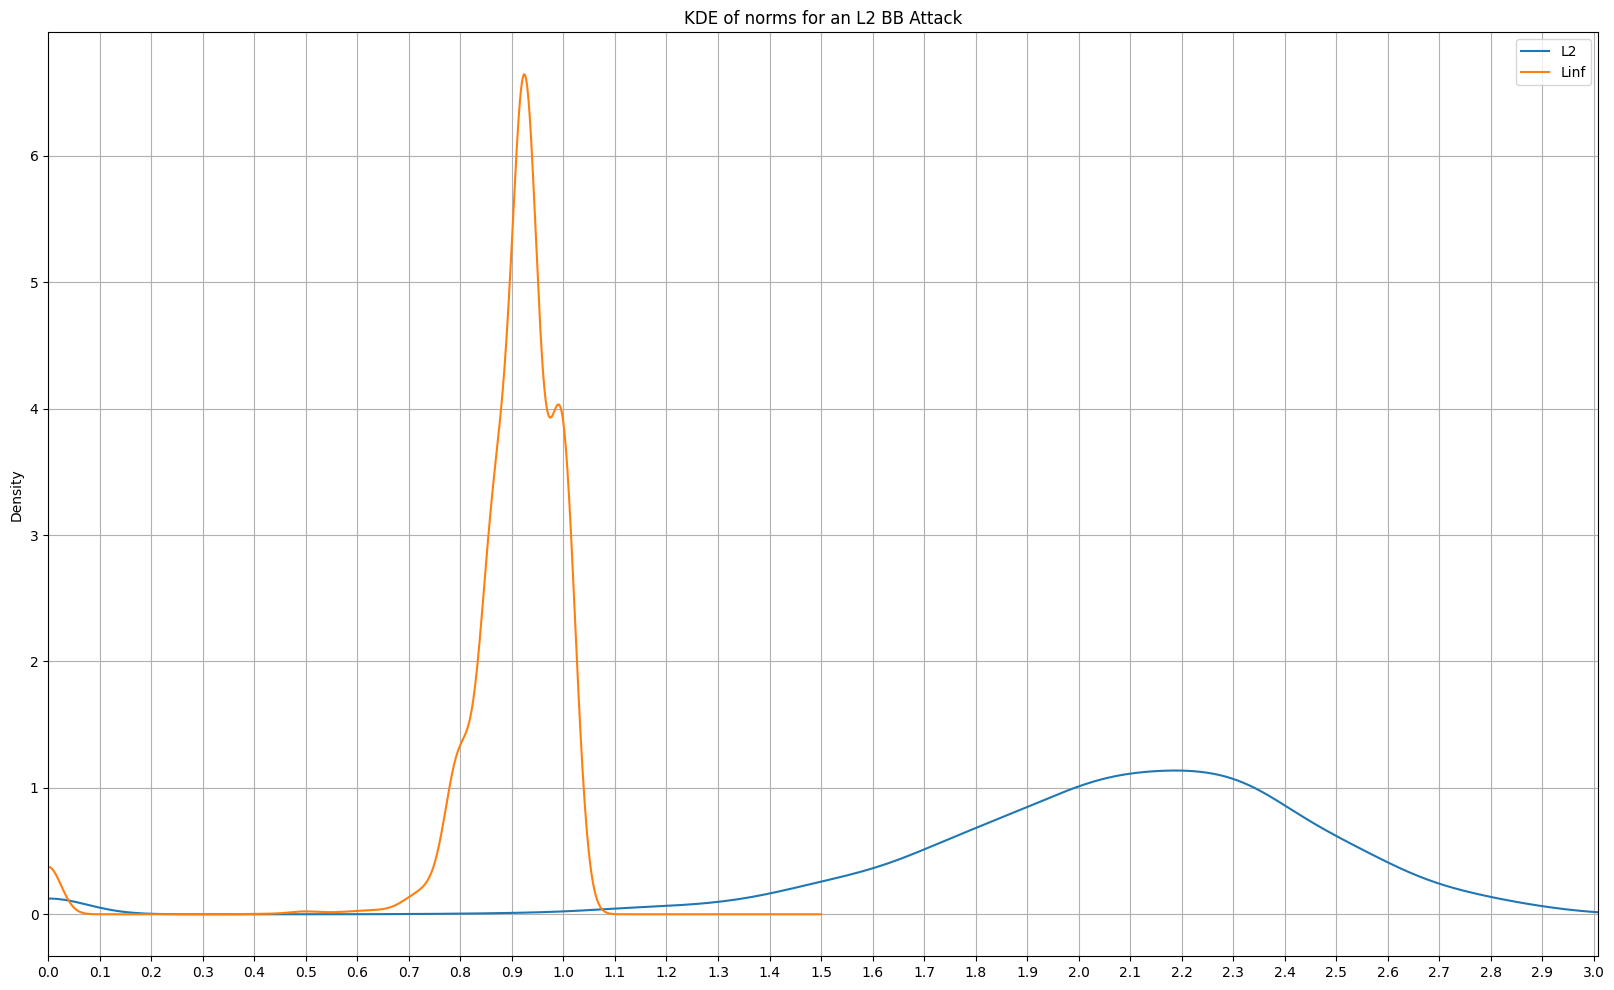

In [71]:
df_norms.plot.kde(grid=True, 
                   xticks=np.arange(start=df_norms.min().min(), stop=df_norms.max().max(), step=0.1),
                   figsize=(20,12),
                   xlim=[df_norms.min().min(),df_norms.max().max()], #NB the max/min of a df is a series, and we need the max/min of the series
                   title='KDE of norms for an L2 BB Attack',
                   xlabel='Linf Norms',
                   legend=True
                   )

We see that the norms for this attack are much higher than for bb linf, and the ASR is lower, this suggests that this attack is less effective are more detectable. NB that a norm of 0 indicates where the attack failed to generate and adversarial sample. 

In [91]:
%%time
l2_adv_reshape_samples = l2_attack.generate(x=samples.to_numpy()[:-1], 
                         y=targets.reshape(-1,1), 
                         x_adv_init=starts, 
                         mask=mask_time)

CPU times: total: 56min 45s
Wall time: 20min 39s


ASR for target reshaped l2 attack

In [94]:
l2_adv_reshape_preds = np.argmax(victim_policy.predict(l2_adv_reshape_samples), axis=1)
np.count_nonzero(l2_adv_reshape_preds == targets)/l2_adv_reshape_samples.shape[0]

0.8851467062450051

In [95]:
%%time
l2_adv_noinit_samples = l2_attack.generate(x=samples.to_numpy()[:-1], 
                         y=targets, 
                         #x_adv_init=starts, 
                         mask=mask_time)

Starting points had predicted class: [19  0 19 ... 19  1 19]
But the target was: [19  0 19 ... 19  1 19]

Failed to find advsersarial starting points, original samples returned


CPU times: total: 49min 4s
Wall time: 49min 4s


ASR for target no init l2 attack

In [96]:
l2_adv_noinit_preds = np.argmax(victim_policy.predict(l2_adv_noinit_samples), axis=1)
np.count_nonzero(l2_adv_noinit_preds == targets)/l2_adv_noinit_samples.shape[0]

0.02374700308254367

Try the best of l2 (with or without the reshape) without the adv_init

In [70]:
df_norms.describe()

,L2,Linf
count,8759.000000,8759.000000
mean,2.048691,0.894112
std,0.466913,0.155077
min,0.000000,0.000000
25%,1.858344,0.878788
50%,2.111387,0.922743
75%,2.330084,0.969697
max,3.008110,1.000000


In [72]:
kwargs = dict(norm=np.inf,
        targeted=True, #default false
        overshoot=1.1, #1.1,
        steps=1000,
        lr=1e-3,
        lr_decay=0.5,
        lr_num_decay=20,
        momentum=0.8,
        binary_search_steps=10,
        init_size=1_000_000, #default 100, finds sample matching the target class through iterative random search
        batch_size=1000,
        )
linf_attack = BBA(estimator=victim_policy, **kwargs)

In [89]:
%%time
linf_adv_samples = linf_attack.generate(x=inputs, 
                         y=targets, 
                         x_adv_init=starts, 
                         mask=mask_time)

CPU times: total: 55min 41s
Wall time: 19min 37s


Linf ASR

In [90]:
linf_adv_preds = np.argmax(victim_policy.predict(linf_adv_samples), axis=1)
np.count_nonzero(linf_adv_preds == targets)/l2_adv_samples.shape[0]

0.9314990295695855

In [84]:
%%time
linf_adv_samples = linf_attack.generate(x=inputs, 
                         y=targets.reshape(-1,1),
                         #x_adv_init=starts, 
                         mask=mask_time)

CPU times: total: 1h 9min 56s
Wall time: 33min 45s


Linf ASR with reshaped targets

In [88]:
linf_adv_preds = np.argmax(victim_policy.predict(linf_adv_samples), axis=1)
np.count_nonzero(linf_adv_preds == targets)/linf_adv_samples.shape[0]

0.9691745633063135

In [76]:
kwargs = dict(norm=np.inf,
        targeted=True, #default false
        overshoot=1.1, #1.1,
        steps=1000,
        lr=1e-3,
        lr_decay=0.5,
        lr_num_decay=20,
        momentum=0.8,
        binary_search_steps=10,
        init_size=1_000_000, #default 100, finds sample matching the target class through iterative random search
        batch_size=1000,
        )
linf2_attack = BBA(estimator=victim_policy, **kwargs)

In [79]:
targets

array([19,  0, 19, ..., 19,  1, 19], dtype=int64)

Removing the inits seems to hit performance hard below

In [77]:
%%time
linf2_adv_samples = linf2_attack.generate(x=inputs, 
                         y=targets, 
                         #x_adv_init=starts, #faster without these?! because the attack wasn't running after a failed search?
                         mask=mask_time)

Starting points had predicted class: [19  0 19 ... 19  1 19]
But the target was: [19  0 19 ... 19  1 19]

Failed to find advsersarial starting points, original samples returned


CPU times: total: 14min 43s
Wall time: 14min 42s


Linf ASR

In [86]:
linf2_adv_preds = np.argmax(victim_policy.predict(linf2_adv_samples), axis=1)
np.count_nonzero(linf2_adv_preds == targets)/l2_adv_samples.shape[0]

0.02374700308254367